In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

**Data Loading & Class Weights**

In [ ]:
# Constants
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
data_dir = pathlib.Path("/content/teaLeafBD")

# 1. Create Datasets
print("Creating datasets...")
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Classes found: {class_names}")

# 2. Calculate Class Weights
print("Calculating class weights...")
train_labels = []
for images, labels in train_ds:
    train_labels.extend(labels.numpy())

class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights_array))
print(f"Class Weights: {class_weights}")

# 3. Optimize Datasets
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Creating datasets...
Found 5276 files belonging to 7 classes.
Using 4221 files for training.
Found 5276 files belonging to 7 classes.
Using 1055 files for validation.
Classes found: ['1. Tea algal leaf spot', '2. Brown Blight', '3. Gray Blight', '4. Helopeltis', '5. Red spider', '6. Green mirid bug', '7. Healthy leaf']
Calculating class weights...
Class Weights: {0: np.float64(1.763157894736842), 1: np.float64(1.4707317073170731), 2: np.float64(0.7344701583434835), 3: np.float64(1.2641509433962264), 4: np.float64(1.4425837320574162), 5: np.float64(0.5958498023715415), 6: np.float64(0.8137651821862348)}


**ConvNeXtTiny Model Definition**

In [ ]:
# 1. Data Augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.3),
  tf.keras.layers.RandomZoom(0.3),
  tf.keras.layers.RandomContrast(0.2),
  tf.keras.layers.RandomTranslation(0.1, 0.1),
  tf.keras.layers.RandomBrightness(0.2),
])

# 2. Base Model: ConvNeXtTiny
base_model = tf.keras.applications.ConvNeXtTiny(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
# Start frozen
base_model.trainable = False

# Create the model pipeline
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.convnext.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = tf.keras.layers.Dense(num_classes)(x)

model = tf.keras.Model(inputs, outputs, name="Tea_Disease_ConvNeXt")

model.summary()

111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "Tea_Disease_ConvNeXt"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_tiny (Functional)      │ (None, 768)            │    27,820,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         5,383 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,825,511 (106.15 MB)

 Trainable params: 5,383 (21.03 KB)

 Non-trainable params: 27,820,128 (106.13 MB)

**Initial Training (Frozen)**

In [ ]:
# --- COMPILE WITH AdamW ---
model.compile(
  optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc']
)

# --- CALLBACKS  ---
callbacks_list = [
    # Stop if validation loss doesn't improve for 5 epochs
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
    ),
    # Reduce Learning Rate by 5x if validation loss gets stuck for 2 epochs
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1
    )
]

print("\n--- Training top layers ---")
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15,
  callbacks=callbacks_list,
  class_weight=class_weights
)


--- Training top layers ---
Epoch 1/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 110s 471ms/step - acc: 0.2468 - loss: 2.3163 - val_acc: 0.5469 - val_loss: 1.2691 - learning_rate: 0.0010
Epoch 2/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 53s 402ms/step - acc: 0.5389 - loss: 1.3197 - val_acc: 0.6398 - val_loss: 1.0407 - learning_rate: 0.0010
Epoch 3/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 53s 401ms/step - acc: 0.6144 - loss: 1.1356 - val_acc: 0.6389 - val_loss: 0.9868 - learning_rate: 0.0010
Epoch 4/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 53s 404ms/step - acc: 0.6419 - loss: 0.9962 - val_acc: 0.6825 - val_loss: 0.8901 - learning_rate: 0.0010
Epoch 5/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 53s 404ms/step - acc: 0.6663 - loss: 0.9917 - val_acc: 0.7081 - val_loss: 0.8445 - learning_rate: 0.0010
Epoch 6/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 53s 404ms/step - acc: 0.6498 - loss: 0.9632 - val_acc: 0.7109 - val_loss: 0.8148 - learning_rate: 0.0010
Epoch 7/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 53s 403ms/step - acc: 0.6799 - loss: 0.9099 - val_acc: 0.692

**Fine-Tuning**

In [ ]:
base_model.trainable = True

# OPTIMIZER & COMPILATION
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

# SMART CALLBACKS

fine_tune_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=6,
        restore_best_weights=True,
        verbose=1
    ),

    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-7,
        verbose=1
    )
]

# TRAIN
total_epochs = 50 + history.epoch[-1]

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=history.epoch[-1],
    epochs=total_epochs,
    callbacks=fine_tune_callbacks,
    class_weight=class_weights
)

Epoch 15/64
132/132 ━━━━━━━━━━━━━━━━━━━━ 234s 1s/step - acc: 0.7268 - loss: 0.7932 - val_acc: 0.7763 - val_loss: 0.6519 - learning_rate: 1.0000e-05
Epoch 16/64
132/132 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - acc: 0.7906 - loss: 0.6053 - val_acc: 0.7858 - val_loss: 0.5951 - learning_rate: 1.0000e-05
Epoch 17/64
132/132 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - acc: 0.8107 - loss: 0.5545 - val_acc: 0.8104 - val_loss: 0.5280 - learning_rate: 1.0000e-05
Epoch 18/64
132/132 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - acc: 0.8230 - loss: 0.4880 - val_acc: 0.8246 - val_loss: 0.5103 - learning_rate: 1.0000e-05
Epoch 19/64
132/132 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - acc: 0.8550 - loss: 0.4170 - val_acc: 0.8332 - val_loss: 0.4807 - learning_rate: 1.0000e-05
Epoch 20/64
132/132 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - acc: 0.8513 - loss: 0.4093 - val_acc: 0.8332 - val_loss: 0.4701 - learning_rate: 1.0000e-05
Epoch 21/64
132/132 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - acc: 0.8605 - loss: 0.3965 - val_acc: 0.8455 - val_loss:

**Evaluation & Confusion Matrix**

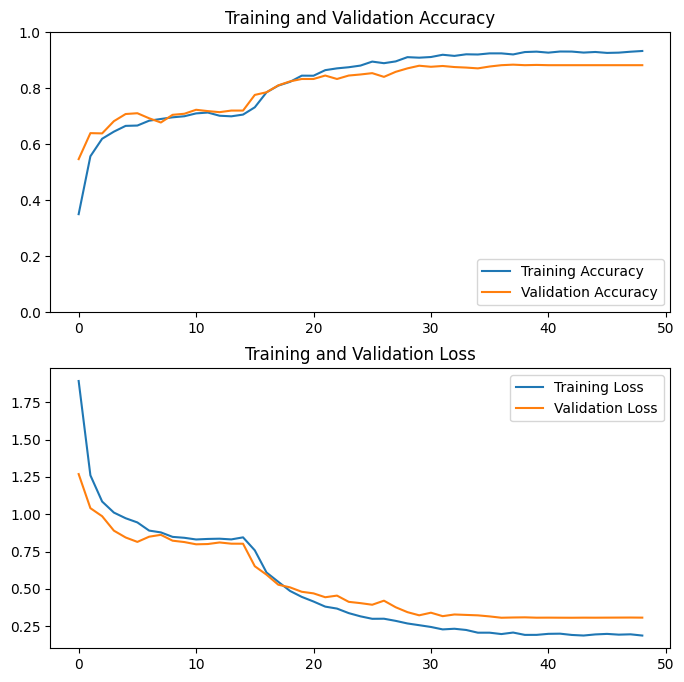

Generating Classification Report...
                        precision    recall  f1-score   support

1. Tea algal leaf spot       0.65      0.92      0.76        76
       2. Brown Blight       0.82      0.64      0.72        96
        3. Gray Blight       0.89      0.88      0.88       192
         4. Helopeltis       0.98      0.73      0.84       130
         5. Red spider       0.92      0.88      0.90        97
    6. Green mirid bug       0.89      0.96      0.92       270
       7. Healthy leaf       0.95      0.99      0.97       194

              accuracy                           0.88      1055
             macro avg       0.87      0.86      0.86      1055
          weighted avg       0.89      0.88      0.88      1055



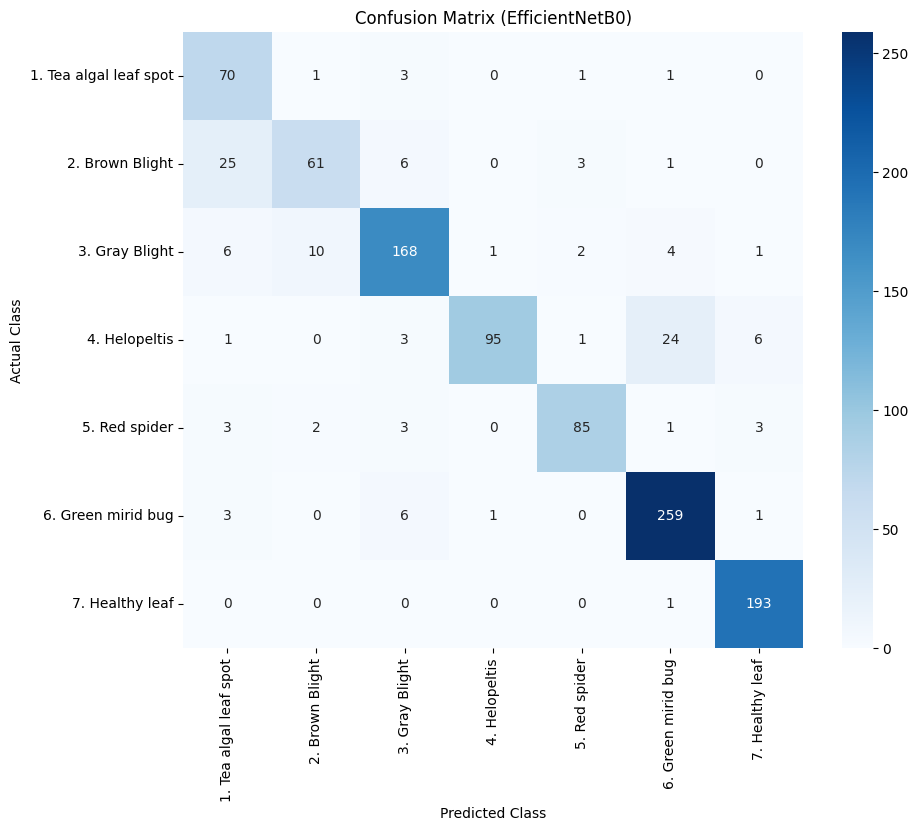

In [ ]:
# 1. Plot Training History
acc = history.history['acc'] + history_fine.history['acc']
val_acc = history.history['val_acc'] + history_fine.history['val_acc']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 2. Classification Report
print("Generating Classification Report...")
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(preds.argmax(axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))

# 3. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix (EfficientNetB0)')
plt.show()

In [ ]:
import pickle
from google.colab import files

# Save as .keras
model_name = 'tea_leaf_convnext.keras'
model.save(model_name)
print(f"Model saved as {model_name}")

# Save class names
with open('class_names.pkl', 'wb') as f:
    pickle.dump(class_names, f)

# Download
files.download(model_name)
files.download('class_names.pkl')

Model saved as tea_leaf_convnext.keras


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>